<a href="https://colab.research.google.com/github/ssrbazpur/BigQuery/blob/master/Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

In [0]:
project_id = 'nyc-taxi-265120' 
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

In [0]:

query = """
with wd as (
    Select 
cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
       MIN(temp) temp,  MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2018` WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 

UNION ALL

select cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
       MIN(temp) temp,  MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019` WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `nyc-taxi-265120.hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
wd.temp,
wd.mintemp, 
wd.maxtemp,
wd.rain,
td.pickups,
ST_X(p) as longitude,
ST_Y(p) as latitude
FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
where wd.year = td.year AND
wd.daynumber = td.daynumber
group by year,zone_id,time,daynumber,hour,pickups,longitude,latitude,dayofweek,temp, mintemp, maxtemp, rain

"""
df1 = client.query(query).to_dataframe()


In [0]:
df2=df1

In [0]:
 import numpy as np
 df2['dayno']= np.where(df2['year']=='2019', df2['daynumber']+365, df2['daynumber'])

In [26]:
df2.head()

,year,zone_id,time,daynumber,hour,dayofweek,temp,mintemp,maxtemp,rain,pickups,longitude,latitude,dayno
0,2019,258,2019-06-27 19:00:00+00:00,178,19,5,82.1,69.1,90.0,0.0,0.0,-73.855767,40.688721,543
1,2019,258,2019-06-28 00:00:00+00:00,179,0,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544
2,2019,258,2019-06-28 12:00:00+00:00,179,12,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544
3,2019,258,2019-06-28 13:00:00+00:00,179,13,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544
4,2019,258,2019-06-28 23:00:00+00:00,179,23,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544


In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4571463 entries, 0 to 4571462
Data columns (total 14 columns):
year         object
zone_id      object
time         datetime64[ns, UTC]
daynumber    int64
hour         int64
dayofweek    object
temp         float64
mintemp      float64
maxtemp      float64
rain         float64
pickups      float64
longitude    float64
latitude     float64
dayno        int64
dtypes: datetime64[ns, UTC](1), float64(7), int64(3), object(3)
memory usage: 488.3+ MB


In [20]:
df2.head()

,year,zone_id,time,daynumber,hour,dayofweek,temp,mintemp,maxtemp,rain,pickups,longitude,latitude,dayno
0,2019,258,2019-06-27 19:00:00+00:00,178,19,5,82.1,69.1,90.0,0.0,0.0,-73.855767,40.688721,543
1,2019,258,2019-06-28 00:00:00+00:00,179,0,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544
2,2019,258,2019-06-28 12:00:00+00:00,179,12,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544
3,2019,258,2019-06-28 13:00:00+00:00,179,13,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544
4,2019,258,2019-06-28 23:00:00+00:00,179,23,6,82.5,71.1,93.0,0.0,0.0,-73.855767,40.688721,544


In [0]:
df2.drop('time', axis=1, inplace=True)
df2["zone_id"] = df2["zone_id"].astype(int)
df2["daynumber"] = df2["daynumber"].astype(int)
df2["year"] = df2["year"].astype(int)
df2.drop('longitude', axis=1, inplace=True)
df2.drop('latitude', axis=1, inplace=True)

df2.drop('mintemp', axis=1, inplace=True)
df2.drop('maxtemp', axis=1, inplace=True)
df2["dayofweek"] = df2["dayofweek"].astype(int)
y=df2['pickups']
X=df2.drop('pickups', axis=1)



In [0]:
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test=train_test_split( X, y, test_size=0.30, random_state=0)

In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [31]:
reg = xgb.XGBRegressor(n_estimators=500)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True) # Change verbose to True if you want to see it train

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:116.174	validation_1-rmse:116.123
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:112.857	validation_1-rmse:112.813
[2]	validation_0-rmse:110.328	validation_1-rmse:110.321
[3]	validation_0-rmse:108.279	validation_1-rmse:108.277
[4]	validation_0-rmse:106.141	validation_1-rmse:106.156
[5]	validation_0-rmse:104.142	validation_1-rmse:104.226
[6]	validation_0-rmse:102.967	validation_1-rmse:103.135
[7]	validation_0-rmse:101.779	validation_1-rmse:101.916
[8]	validation_0-rmse:100.816	validation_1-rmse:101.043
[9]	validation_0-rmse:100.002	validation_1-rmse:100.275
[10]	validation_0-rmse:99.1929	validation_1-rmse:99.5202
[11]	validation_0-rmse:98.4575	validation_1-rmse:98.8612
[12]	validation_0-rmse:97.2747	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

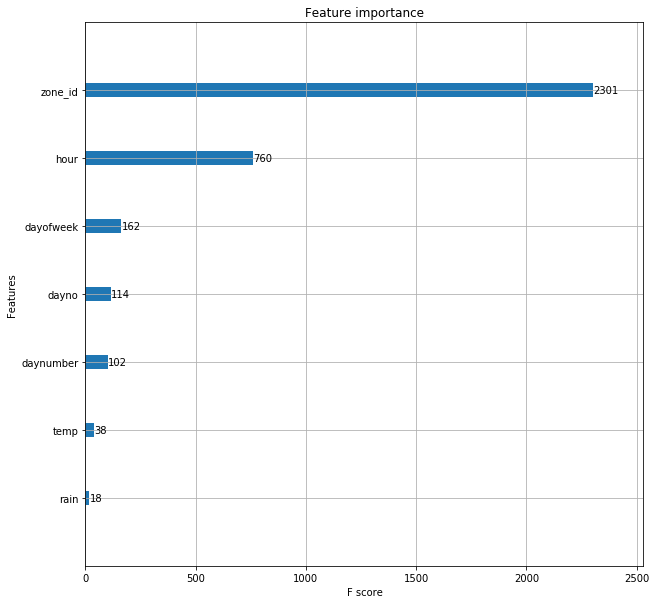

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(reg, max_num_features=7, ax=ax)

In [0]:
a=reg.predict(X_test)

In [34]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, a) ** 0.5)

The rmse of prediction is: 46.27494749422996


In [0]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(a, y_test)
accuracy

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
from random import randint
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


In [0]:
regr1 = RandomForestRegressor()#(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
param_dist = {"max_depth": [3, None],
              "max_features": ['sqrt' , 'log2' ],
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "n_estimators":[35,40,45]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regr1, param_distributions=param_dist,n_iter=n_iter_search)
random_search.fit(df_train, tsne_train_output)
print(random_search.best_params_)

In [0]:
regr1 = RandomForestRegressor()#(max_features=’sqrt’,min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
param_dist = {“max_depth”: [3, None],
 “max_features”: [‘sqrt’ , ‘log2’ ],
 “min_samples_split”: randint(2, 11),
 “min_samples_leaf”: randint(1, 11),
 “n_estimators”:[35,40,45]
 }
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regr1, param_distributions=param_dist,n_iter=n_iter_search)
random_search.fit(df_train, tsne_train_output)
print(random_search.best_params_)

In [0]:
import lightgbm as lgb
print("Fitting...")
gbm= lgb.LGBMClassifier()
parameters = gbm.fit( X_train, y_train )
print("Fitted...")

Fitting...


In [0]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [0]:
X_train

array([[-0.99951949, -0.63379894, -0.42175598, ...,  1.50301723,
        -0.11749091,  0.12871062],
       [ 1.00048074,  0.00759596,  0.90959839, ..., -1.49684007,
         0.39231533, -0.47103758],
       [ 1.00048074, -0.46363295,  0.08225674, ...,  0.50306479,
         1.37271195, -0.47103758],
       ...,
       [ 1.00048074, -0.12330096, -0.40273663, ..., -0.49688764,
         0.62761052, -0.47103758],
       [ 1.00048074,  1.18566825,  0.43411469, ...,  1.50301723,
         1.17663263, -0.47103758],
       [-0.99951949, -1.72024338,  0.85254035, ..., -1.49684007,
         0.4819516 , -0.47103758]])

In [0]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

In [0]:
train = df1.sort_values(by='time', ascending=True) # Sorting the data in increasing order of Date and then splitting.
y = train['pickups']
X = train.drop(['pickups'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

In [0]:
train.head()

,year,zone_id,time,daynumber,hour,dayofweek,temp,mintemp,maxtemp,rain,pickups,longitude,latitude
1189150,2018,165,2018-01-01 00:00:00+00:00,1,0,2,12.6,8.1,21.9,0.0,0.0,-73.956824,40.620924
766710,2018,80,2018-01-01 00:00:00+00:00,1,0,2,12.6,8.1,21.9,0.0,24.0,-73.936794,40.715370
1307031,2018,228,2018-01-01 00:00:00+00:00,1,0,2,12.6,8.1,21.9,0.0,4.0,-74.011273,40.652354
1522974,2018,147,2018-01-01 00:00:00+00:00,1,0,2,12.6,8.1,21.9,0.0,0.0,-73.898957,40.819676
61967,2018,61,2018-01-01 00:00:00+00:00,1,0,2,12.6,8.1,21.9,0.0,7.0,-73.939287,40.674470


In [0]:
df1.head()

,year,zone_id,time,daynumber,hour,dayofweek,temp,mintemp,maxtemp,rain,pickups,longitude,latitude
0,2018,54,2018-12-03 13:00:00+00:00,337,13,2,54.2,42.1,57.0,0.41,0.0,-74.002911,40.687201
1,2018,54,2018-12-05 20:00:00+00:00,339,20,4,33.1,28.9,46.0,0.00,0.0,-74.002911,40.687201
2,2018,54,2018-12-07 21:00:00+00:00,341,21,6,37.8,32.0,41.0,0.00,0.0,-74.002911,40.687201
3,2018,54,2018-12-08 10:00:00+00:00,342,10,7,30.7,26.1,39.9,0.00,0.0,-74.002911,40.687201
4,2018,54,2018-12-09 01:00:00+00:00,343,1,1,33.3,26.1,37.0,0.00,0.0,-74.002911,40.687201


In [0]:
def wmae_train(test, pred): 
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if   is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error
def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error
def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

In [0]:
# Importing the most popular regression libraries.
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

In [0]:
error_cv_rf = []
error_train_rf = []
max_depth = [1,5,10,15,20,25,30,35]
n_estimators = [10,20,30,40,50,60,70,80]
rf_hyperparams = []
"""Calculating train and CV errors for maximum depth and number of estimators parameters."""
for i in max_depth: 
    for j in n_estimators: 
        rf = RandomForestRegressor(max_depth=i, n_estimators=j) 
        rf.fit(X_train, y_train) 
        y_pred_cv_rf = rf.predict(X_cv) 
        y_pred_train_rf = rf.predict(X_train) 
        error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) 
        error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) 
        rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) 

TypeError: ignored